In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [420]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
q = 0
T = 4/52 #20/52
K = 50
type = 'c'

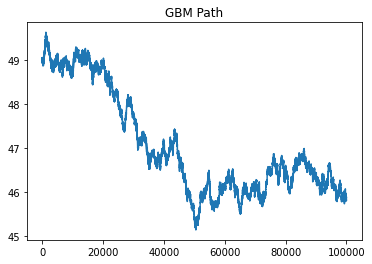

In [421]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
M = 100000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [422]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma/(2*np.sqrt(T))


#### Delta Hedging

In [423]:
summary_df = pd.DataFrame(list(zip(S, delta_array, gamma_array, theta_array)), columns=['Stock_Price', 'Delta', 'Gamma', 'Theta'])

In [424]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Interest_Cost'] = summary_df['Cumulative_Cost']*(r*dt)
summary_df['Cumulative_Cost_Inc_Interest'] =  summary_df['Cumulative_Cost'].add(summary_df['Interest_Cost'].shift()).fillna(summary_df['Cumulative_Cost'])
summary_df['Portfolio_Delta'] = option_exposure*summary_df['Delta'] + summary_df['Shares_Held']*1
summary_df['Portfolio_Gamma'] = option_exposure*summary_df['Gamma'] + summary_df['Shares_Held']*0
summary_df['Portfolio_Theta'] = option_exposure*summary_df['Theta'] + summary_df['Shares_Held']*0

hedging_cost = -K*option_exposure - summary_df['Cumulative_Cost_Inc_Interest'].iloc[-1]  # Cash received for stock - total cost  

print(f'Hedging PnL = ${hedging_cost}')
summary_df

Hedging PnL = $4928322.817383296


,Stock_Price,Delta,Gamma,Theta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Interest_Cost,Cumulative_Cost_Inc_Interest,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta
0,49.000000,0.394682,0.141631,-7.731297,39468.185899,39468.185899,1.933941e+06,1.933941e+06,0.074383,1.933941e+06,0.0,-14163.140784,773129.693209
1,48.999386,0.394594,0.141625,-7.730616,39459.400717,-8.785182,-4.304685e+02,1.933511e+06,0.074367,1.933511e+06,0.0,-14162.525265,773061.597722
2,48.999619,0.394626,0.141628,-7.730913,39462.613703,3.212987,1.574351e+02,1.933668e+06,0.074373,1.933668e+06,0.0,-14162.844704,773091.309846
3,48.991750,0.393511,0.141542,-7.721830,39351.108945,-111.504758,-5.462813e+03,1.928205e+06,0.074162,1.928205e+06,0.0,-14154.163957,772183.045535
4,48.974657,0.391092,0.141348,-7.701897,39109.247232,-241.861713,-1.184509e+04,1.916360e+06,0.073707,1.916360e+06,0.0,-14134.840096,770189.712339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,45.895896,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000e+00,7.167718e+04,0.002757,7.167718e+04,0.0,0.000000,0.000000
99996,45.898308,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000e+00,7.167718e+04,0.002757,7.167718e+04,0.0,0.000000,0.000000
99997,45.889751,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000e+00,7.167718e+04,0.002757,7.167718e+04,0.0,0.000000,0.000000
99998,45.896782,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000e+00,7.167718e+04,0.002757,7.167718e+04,0.0,0.000000,0.000000


In [425]:
profit_df = summary_df[['Stock_Price', 'Portfolio_Delta', 'Portfolio_Gamma', 'Portfolio_Theta', 'Shares_Held']].copy()
profit_df['Stock_Ret'] = profit_df['Stock_Price'].div(profit_df['Stock_Price'].shift()) - 1
profit_df['Stock_Change'] = profit_df['Stock_Price'].sub(profit_df['Stock_Price'].shift())
profit_df['BS_Option_Price'] = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)
profit_df['Option_Exposure'] = option_exposure*profit_df['BS_Option_Price']
profit_df['Share_Exposure'] = profit_df['Shares_Held'].mul(profit_df['Stock_Price'])
profit_df['Option_PnL'] = -profit_df['Option_Exposure'].shift().sub(profit_df['Option_Exposure'])
profit_df['Share_PnL'] = profit_df['Share_Exposure'].mul(profit_df['Stock_Ret'].shift(-1)).shift()
profit_df['Portfolio_PnL'] = profit_df['Share_PnL'].add(profit_df['Option_PnL'])
profit_df['Projected_Portfolio_Pnl_Delta'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])

profit_df = profit_df.astype(float).round(4)
profit_df

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))


,Stock_Price,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta,Shares_Held,Stock_Ret,Stock_Change,BS_Option_Price,Option_Exposure,Share_Exposure,Option_PnL,Share_PnL,Portfolio_PnL,Projected_Portfolio_Pnl_Delta,Projected_Portfolio_Pnl_Delta_Gamma,Projected_Portfolio_Pnl_Delta_Gamma_Theta,Projected_Portfolio_Pnl_Delta_Theta
0,49.0000,0.0,-14163.1408,773129.6932,39468.1859,NaN,NaN,0.7363,-73627.6539,1.933941e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.9994,0.0,-14162.5253,773061.5977,39459.4007,-0.0000,-0.0006,0.7360,-73602.8273,1.933486e+06,24.8266,-24.2346,0.5920,-0.0,-0.0027,0.5921,0.5947
2,48.9996,0.0,-14162.8447,773091.3098,39462.6137,0.0000,0.0002,0.7361,-73611.4323,1.933653e+06,-8.6050,9.1993,0.5943,0.0,-0.0004,0.5943,0.5947
3,48.9917,0.0,-14154.1640,772183.0455,39351.1089,-0.0002,-0.0079,0.7330,-73300.7389,1.927880e+06,310.6934,-310.5379,0.1556,-0.0,-0.4385,0.1562,0.5947
4,48.9747,0.0,-14134.8401,770189.7123,39109.2472,-0.0003,-0.0171,0.7263,-72629.5871,1.915362e+06,671.1518,-672.6261,-1.4743,-0.0,-2.0677,-1.4737,0.5940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,45.8959,0.0,0.0000,0.0000,0.0000,0.0001,0.0044,0.0000,-0.0000,0.000000e+00,-0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
99996,45.8983,0.0,0.0000,0.0000,0.0000,0.0001,0.0024,0.0000,-0.0000,0.000000e+00,-0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
99997,45.8898,0.0,0.0000,0.0000,0.0000,-0.0002,-0.0086,0.0000,-0.0000,0.000000e+00,-0.0000,-0.0000,-0.0000,-0.0,0.0000,0.0000,0.0000
99998,45.8968,0.0,0.0000,0.0000,0.0000,0.0002,0.0070,0.0000,-0.0000,0.000000e+00,-0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000


In [426]:
print(profit_df['Portfolio_PnL'].sum()) # Actual PnL of the portfolio
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t

1950.4734999999996
-21870.5017
1950.2859


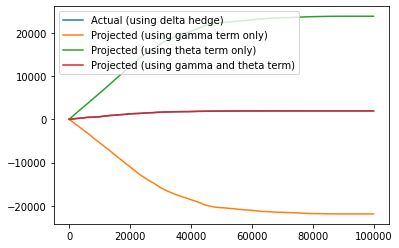

In [427]:
#ax, fig = plt.figure()
plt.plot(profit_df['Portfolio_PnL'].cumsum(), label='Actual (using delta hedge)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].cumsum(), label='Projected (using gamma term only)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Theta'].cumsum(), label='Projected (using theta term only)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].cumsum(), label='Projected (using gamma and theta term)')
plt.legend()